In [29]:
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [22]:
# Load the dataset
df = pd.read_csv(r'D:\Tag\Vocal Gender Classifier\balanced-all.csv')  # Replace with your actual CSV file path

# Display some .npy files
for index, row in df.iterrows():
    if index >= 5:  # Display only the first 5 files
        break
    file_path = row['filename']
    gender = row['gender']
    
    # Load features from .npy file
    features = np.load(file_path)
    
    print(f"File: {file_path}")
    print(f"Gender: {gender}")
    print(f"Shape: {features.shape}")
    print(f"Data (first 5 rows):\n{features[:5]}")
    print("="*50)

X = []
y = []

File: data/cv-other-train/sample-069205.npy
Gender: female
Shape: (128,)
Data (first 5 rows):
[0.83369184 1.84069288 0.72115082 0.11549401 0.40520552]
File: data/cv-valid-train/sample-063134.npy
Gender: female
Shape: (128,)
Data (first 5 rows):
[0.00034479 0.00037825 0.00070243 0.00123594 0.00299075]
File: data/cv-other-train/sample-080873.npy
Gender: female
Shape: (128,)
Data (first 5 rows):
[0.00019014 0.000244   0.00046043 0.00158498 0.02741824]
File: data/cv-other-train/sample-105595.npy
Gender: female
Shape: (128,)
Data (first 5 rows):
[0.00553466 0.00442336 0.015127   0.02795169 0.17951205]
File: data/cv-valid-train/sample-144613.npy
Gender: female
Shape: (128,)
Data (first 5 rows):
[0.00105059 0.00095013 0.0020361  0.00779054 0.01700675]


In [23]:
# Step 2: Load the .npy files
for index, row in df.iterrows():
    file_path = row['filename']
    gender = row['gender']
    
    # Load features from .npy file
    features = np.load(file_path)
    X.append(features)
    y.append(gender)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

In [24]:
# Step 3: Encode the gender labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [26]:
# Step 4: Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Save the trained model
joblib.dump(model, 'gender_classifier.pkl')

              precision    recall  f1-score   support

      female       0.94      0.94      0.94      6625
        male       0.95      0.95      0.95      6763

    accuracy                           0.95     13388
   macro avg       0.95      0.95      0.95     13388
weighted avg       0.95      0.95      0.95     13388



['gender_classifier.pkl']

In [30]:
# Evaluate the model on training data
train_predictions = model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

In [31]:
# Evaluate the model on validation data
val_predictions = model.predict(X_test)
val_accuracy = accuracy_score(y_test, val_predictions)

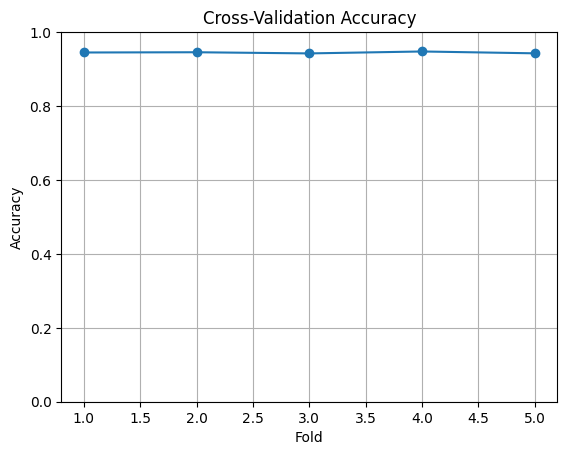

Cross-Validation Scores: [0.94487601 0.94554825 0.94241111 0.94763577 0.94263091]
Mean Accuracy: 0.9446204103178463
Standard Deviation: 0.0019420447215511964


In [35]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X, y_encoded, cv=5)

# Plot cross-validation accuracy
plt.plot(np.arange(1, len(cv_scores) + 1), cv_scores, marker='o')
plt.title('Cross-Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid()
plt.show()

print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Accuracy: {cv_scores.mean()}')
print(f'Standard Deviation: {cv_scores.std()}')


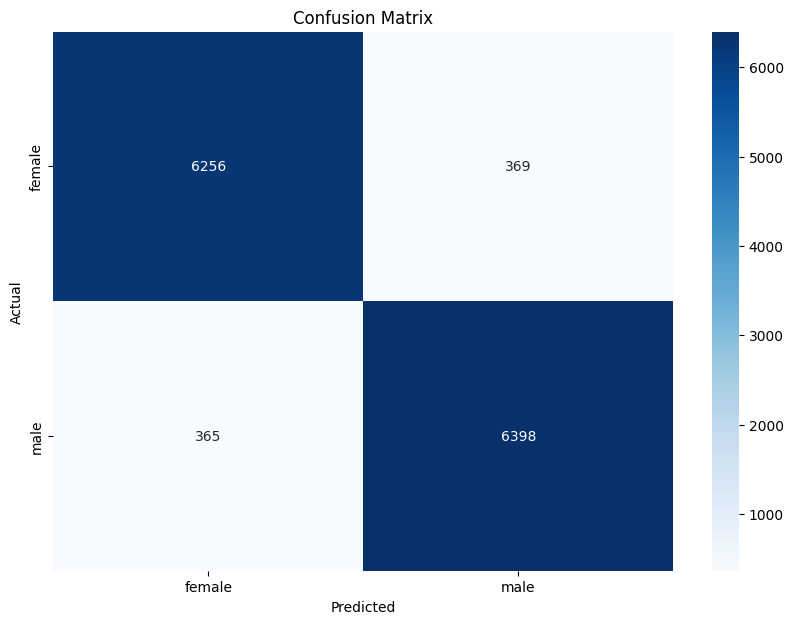

In [21]:
# Generate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [1]:
import numpy as np
import librosa
import joblib

# Function to predict gender of a new MP3 file in chunks
def predict_gender(mp3_file, chunk_duration=5, overlap_duration=2):
    # Load the audio file
    y, sr = librosa.load(mp3_file, sr=None)

    # Initialize parameters
    predictions = []
    step_size = chunk_duration - overlap_duration  # Step size for sliding window

    # Load the trained model
    model = joblib.load('gender_classifier.pkl')

    # Sliding window over the audio
    for start in range(0, len(y), step_size * sr):
        end = start + chunk_duration * sr
        chunk = y[start:end]

        # Check if the chunk is empty
        if len(chunk) == 0:
            continue

        # Extract features (MFCCs) for the chunk
        mfccs = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=128)
        
        # Take the mean of the MFCCs
        mfccs_mean = np.mean(mfccs.T, axis=0)
        
        # Reshape for prediction
        mfccs_mean = mfccs_mean.reshape(1, -1)  # Ensure the shape is (1, 128)

        # Predict gender for the chunk
        prediction = model.predict(mfccs_mean)
        
        # Append the prediction (0 for male, 1 for female)
        predictions.append(prediction[0])

    # Count the occurrences of each gender
    male_count = predictions.count(0)  # Count males
    female_count = predictions.count(1)  # Count females

    # Calculate total predictions
    total_predictions = male_count + female_count

    # Output results for each chunk
    for i, gender in enumerate(predictions):
        gender_label = "female" if gender == 1 else "male"  # Assuming 1 is female and 0 is male
        print(f'Chunk {i + 1}: Predicted gender is {gender_label}')

    # Overall result
    print("\nOverall Results:")
    print(f"Total chunks processed: {total_predictions}")
    print(f"Male predictions: {male_count} ({(male_count / total_predictions) * 100:.2f}%)")
    print(f"Female predictions: {female_count} ({(female_count / total_predictions) * 100:.2f}%)")

# Example usage
new_mp3_file = r'D:\Tag\Vocal Gender Classifier\vocals.wav'  # Replace with your MP3 file path
predict_gender(new_mp3_file)


Chunk 1: Predicted gender is female
Chunk 2: Predicted gender is female
Chunk 3: Predicted gender is female
Chunk 4: Predicted gender is female
Chunk 5: Predicted gender is female
Chunk 6: Predicted gender is female
Chunk 7: Predicted gender is female
Chunk 8: Predicted gender is male
Chunk 9: Predicted gender is male
Chunk 10: Predicted gender is male
Chunk 11: Predicted gender is male
Chunk 12: Predicted gender is female
Chunk 13: Predicted gender is female
Chunk 14: Predicted gender is male
Chunk 15: Predicted gender is female
Chunk 16: Predicted gender is female
Chunk 17: Predicted gender is female
Chunk 18: Predicted gender is female
Chunk 19: Predicted gender is female
Chunk 20: Predicted gender is male
Chunk 21: Predicted gender is male
Chunk 22: Predicted gender is female
Chunk 23: Predicted gender is male
Chunk 24: Predicted gender is male
Chunk 25: Predicted gender is female
Chunk 26: Predicted gender is female
Chunk 27: Predicted gender is female
Chunk 28: Predicted gender i

In [1]:
import numpy as np
import librosa
import joblib
import torch
import openunmix
import torchaudio
import simpleaudio as sa
from pydub import AudioSegment

# Function to separate and save vocals and accompaniment from an audio file
def separate_audio(audio_path, output_vocals='vocals.wav', output_accompaniment='accompaniment.wav'):
    # Load the pre-trained model
    separator = openunmix.umxl()

    # Load the audio file and preprocess it
    try:
        audio, sample_rate = torchaudio.load(audio_path)
        print(f"Loaded audio shape: {audio.shape}, Sample rate: {sample_rate}")
    except Exception as e:
        print(f"Error loading audio file: {e}")
        return None

    # Ensure audio has the correct shape (1, C, T)
    if audio.dim() == 1:  # mono
        audio = audio.unsqueeze(0).unsqueeze(0)  # Shape (1, 1, T)
    elif audio.dim() == 2:  # stereo
        audio = audio.unsqueeze(0)  # Shape (1, C, T)

    print(f"Audio shape after unsqueeze: {audio.shape}")

    # Perform separation
    with torch.no_grad():  # Disable gradient calculation
        estimates = separator(audio)

    # Check the shape of the estimates
    print(f"Estimates shape: {estimates.shape}")

    # Extract the vocal and accompaniment parts
    if estimates.dim() == 3:
        # Assuming estimates are in the shape [1, 2, C, T]
        vocals = estimates[0, 0]  # First output for vocals
        accompaniment = estimates[0, 1]  # Second output for accompaniment
    elif estimates.dim() == 4 and estimates.shape[1] >= 2:
        # If estimates are in the shape [1, 4, 2, T] (two sources per estimate)
        vocals = estimates[0, 0]  # First channel corresponds to vocals
        accompaniment = estimates[0, 1]  # Second channel corresponds to accompaniment
    else:
        print("Estimation did not return expected shape for vocals and accompaniment. Exiting.")
        return None

    # Check and print the shape of the extracted vocals and accompaniment
    print(f"Extracted vocals shape: {vocals.shape}")
    print(f"Extracted accompaniment shape: {accompaniment.shape}")

    # Ensure we save 2D tensors
    if vocals.dim() == 3:  # If the vocals tensor is still 3D
        vocals = vocals.squeeze(0)  # Reduce to [C, T]

    if accompaniment.dim() == 3:  # If the accompaniment tensor is still 3D
        accompaniment = accompaniment.squeeze(0)  # Reduce to [C, T]

    # Save the vocal audio file
    try:
        torchaudio.save(output_vocals, vocals, sample_rate=sample_rate)  # Save the extracted vocals
        print(f"Separated vocals saved as '{output_vocals}'.")
    except Exception as e:
        print(f"Error saving vocal audio file: {e}")

    # Save the accompaniment audio file
    try:
        torchaudio.save(output_accompaniment, accompaniment, sample_rate=sample_rate)  # Save the extracted accompaniment
        print(f"Separated accompaniment saved as '{output_accompaniment}'.")
        return output_vocals  # Return the vocals file for gender prediction
    except Exception as e:
        print(f"Error saving accompaniment audio file: {e}")
        return None

# Function to predict gender classification of a new MP3 file in chunks
def predict_gender(mp3_file, chunk_duration=30, overlap_duration=2):
    # Load the audio file
    y, sr = librosa.load(mp3_file, sr=None)

    # Initialize parameters
    predictions = []
    step_size = chunk_duration - overlap_duration  # Step size for sliding window

    # Load the trained model
    model = joblib.load('gender_classifier.pkl')

    # Sliding window over the audio
    for start in range(0, len(y), step_size * sr):
        end = start + chunk_duration * sr
        chunk = y[start:end]

        # Check if the chunk is empty
        if len(chunk) == 0:
            continue

        # Extract features (MFCCs) for the chunk
        mfccs = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=128)
        
        # Take the mean of the MFCCs
        mfccs_mean = np.mean(mfccs.T, axis=0)
        
        # Reshape for prediction
        mfccs_mean = mfccs_mean.reshape(1, -1)  # Ensure the shape is (1, 128)

        # Predict gender for the chunk
        gender_prediction = model.predict(mfccs_mean)
        prediction = "female" if gender_prediction == 1 else "male"

        # Append the prediction
        predictions.append(prediction)

    # Count the occurrences of each category
    male_count = predictions.count("male")
    female_count = predictions.count("female")

    # Calculate total predictions
    total_predictions = male_count + female_count

    # Output results for each chunk
    for i, prediction in enumerate(predictions):
        print(f'Chunk {i + 1}: Predicted category is {prediction}')

    # Overall result
    print("\nOverall Results:")
    print(f"Total chunks processed: {total_predictions}")
    print(f"Male predictions: {male_count} ({(male_count / total_predictions) * 100:.2f}%)")
    print(f"Female predictions: {female_count} ({(female_count / total_predictions) * 100:.2f}%)")

# Function to convert and play an audio file
def convert_and_play_audio(file_path):
    try:
        # Convert the audio file to PCM 16-bit format
        audio = AudioSegment.from_wav(file_path)
        audio = audio.set_frame_rate(44100).set_channels(1).set_sample_width(2)
        audio.export("vocals_converted.wav", format="wav")

        # Play the converted audio file
        wave_obj = sa.WaveObject.from_wave_file("vocals_converted.wav")
        play_obj = wave_obj.play()
        play_obj.wait_done()  # Wait until sound has finished playing
        print(f"Playing '{file_path}' is complete.")
    except Exception as e:
        print(f"Error converting or playing audio file: {e}")

# Specify the path to your audio file
audio_file_path = r'D:\Tag\Vocal Gender Classifier\Dataset\Male\male_song_28.mp3'  # Replace with your audio file

# Separate the audio into vocals and accompaniment
vocal_file = separate_audio(audio_file_path)

# If separation was successful, predict gender using the vocal part and then play the vocal part
if vocal_file:
    predict_gender(vocal_file, chunk_duration=30)
    convert_and_play_audio(vocal_file)  # Play the vocal part once prediction is complete


Loaded audio shape: torch.Size([2, 1440000]), Sample rate: 48000
Audio shape after unsqueeze: torch.Size([1, 2, 1440000])
Estimates shape: torch.Size([1, 4, 2, 1440000])
Extracted vocals shape: torch.Size([2, 1440000])
Extracted accompaniment shape: torch.Size([2, 1440000])
Separated vocals saved as 'vocals.wav'.
Separated accompaniment saved as 'accompaniment.wav'.
Chunk 1: Predicted category is female
Chunk 2: Predicted category is male

Overall Results:
Total chunks processed: 2
Male predictions: 1 (50.00%)
Female predictions: 1 (50.00%)


: 